<a href="https://colab.research.google.com/github/protaxY/DLS/blob/main/simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Классификация изображений

Выполнил Федоров Антон (Stepik ID: 460961083)

## Использую готовый код из baseline-a

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 24 11:27:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import pandas as pd

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Так как я пытался сделать transfer learning с inception_v3, то сделаю RESCALE_SIZE равным 299.

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
# RESCALE_SIZE = 224
RESCALE_SIZE = 299

# работаем на видеокарте
DEVICE = torch.device("cuda")

Добавлю в уже имеющимся преобразованием над изображениями аугментацию. Буду дополнительно переворачивать изображения, размывать и применять случайные перспективные преобразования.

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.GaussianBlur(3),
            transforms.RandomPerspective(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)

        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Взгляну на примеры изображений из обучающей выборки.

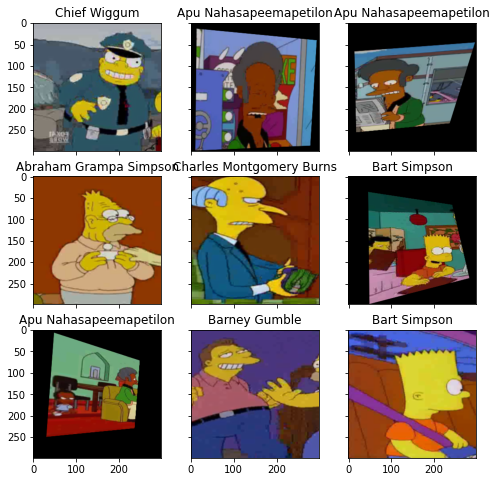

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Использую готовые функции из baseline-а.

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Немного изменю функцию для обучения. Добавлю возможность передачи кастомного оптимизатора и шедулера для learning rate-а.

In [17]:
def train(train_files, val_files, model, optimizer, scheduler, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))

# Обучение моделей

Не буду изобретать велосипед и с ходу попробую воспользоваться уже обученными сетями.

In [20]:
from torchvision import datasets, models, transforms

Далее во всех ячейках будут реализованны transfer learning-модели, которые не дали хорошего результата. Не все попытки их обучения были залиты на kaggle, так как их число в день ограничено. По динамике функции потерь и промежуточным значениям точности в принципе можно было понять, что происходит и стоит ли доводить вариант до конца.

In [ ]:
model = models.inception_v3(weights = True)

model.aux_logits = False
for parameter in model.parameters():
    parameter.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, n_classes)
    )

model.to(DEVICE)
None

/home/prota/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = models.densenet201(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1920, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, n_classes)
    )

model.to(DEVICE)
None

/home/prota/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = models.resnet152(weights = True)

for parameter in model.parameters():
    parameter.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, n_classes)
    )

model.to(DEVICE)
None

/home/prota/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = models.efficientnet_v2_l(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False

model.features[-1].requires_grad = True

model.classifier = nn.Sequential(
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, n_classes)
    )

model.to(DEVICE)
None

/home/prota/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = models.resnet50(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = False
for param in model.fc.parameters():
    param.require_grad = True

num_features = model.fc.in_features

model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.Tanh(),
        nn.Linear(1024, 1024),
        nn.Tanh(),
        nn.Linear(1024, 1024),
        nn.Tanh(),
        nn.Linear(1024, n_classes),
    )

model.to(DEVICE)

model

Последняя модель из неудачных - это предобученный resnet50 с головой из двух скрытых слоев и функцией активации Tanh. Почитав обсуждение в telegram, узнал, что высшей метрики можно добиться и с resnet50, но в моем случае результат в лучше случае оказался 0.8. Узнав, что делали люди из беседы, я решил просто заменить последний слой на слой размерности, необходимой для решения задачи распознавания симпсоснов.

In [21]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.require_grad = False
for param in model.fc.parameters():
    param.require_grad = True

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)

model = model.to(DEVICE)
    
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

# Обучение

Здесь приведены обучения лучшего варианта.

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

history = train(train_dataset, val_dataset, model=model, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.7802863259170555


epoch:   5%|▌         | 1/20 [06:46<2:08:46, 406.65s/it]


Epoch 001 train_loss: 0.7803     val_loss 0.3093 train_acc 0.8329 val_acc 0.9293
loss 0.32635971073318837


epoch:  10%|█         | 2/20 [13:00<1:56:15, 387.53s/it]


Epoch 002 train_loss: 0.3264     val_loss 0.2080 train_acc 0.9195 val_acc 0.9518
loss 0.194498247003934


epoch:  15%|█▌        | 3/20 [19:14<1:48:01, 381.27s/it]


Epoch 003 train_loss: 0.1945     val_loss 0.2098 train_acc 0.9519 val_acc 0.9484
loss 0.14175262181454273


epoch:  20%|██        | 4/20 [25:25<1:40:34, 377.17s/it]


Epoch 004 train_loss: 0.1418     val_loss 0.1852 train_acc 0.9641 val_acc 0.9551
loss 0.11086476303411899


epoch:  25%|██▌       | 5/20 [31:37<1:33:47, 375.14s/it]


Epoch 005 train_loss: 0.1109     val_loss 0.1753 train_acc 0.9709 val_acc 0.9539
loss 0.0505959287152997


epoch:  30%|███       | 6/20 [37:51<1:27:30, 375.03s/it]


Epoch 006 train_loss: 0.0506     val_loss 0.1007 train_acc 0.9885 val_acc 0.9807
loss 0.036162841957370365


epoch:  35%|███▌      | 7/20 [44:03<1:21:00, 373.85s/it]


Epoch 007 train_loss: 0.0362     val_loss 0.0960 train_acc 0.9921 val_acc 0.9807
loss 0.030373634551182388


epoch:  40%|████      | 8/20 [50:12<1:14:28, 372.40s/it]


Epoch 008 train_loss: 0.0304     val_loss 0.0940 train_acc 0.9933 val_acc 0.9811
loss 0.028039218850376434


epoch:  45%|████▌     | 9/20 [56:21<1:08:05, 371.42s/it]


Epoch 009 train_loss: 0.0280     val_loss 0.0899 train_acc 0.9935 val_acc 0.9830
loss 0.027097393634185066


epoch:  50%|█████     | 10/20 [1:02:31<1:01:49, 370.96s/it]


Epoch 010 train_loss: 0.0271     val_loss 0.0954 train_acc 0.9943 val_acc 0.9826
loss 0.021674401492162272


epoch:  55%|█████▌    | 11/20 [1:08:42<55:37, 370.83s/it]


Epoch 011 train_loss: 0.0217     val_loss 0.0846 train_acc 0.9947 val_acc 0.9833
loss 0.018447843937148618


epoch:  60%|██████    | 12/20 [1:14:51<49:21, 370.21s/it]


Epoch 012 train_loss: 0.0184     val_loss 0.0871 train_acc 0.9960 val_acc 0.9823
loss 0.020609003275692477


epoch:  65%|██████▌   | 13/20 [1:21:02<43:13, 370.55s/it]


Epoch 013 train_loss: 0.0206     val_loss 0.0913 train_acc 0.9950 val_acc 0.9830
loss 0.0210474201477063


epoch:  70%|███████   | 14/20 [1:27:13<37:04, 370.82s/it]


Epoch 014 train_loss: 0.0210     val_loss 0.0932 train_acc 0.9949 val_acc 0.9821
loss 0.01952295492716987


epoch:  75%|███████▌  | 15/20 [1:33:22<30:50, 370.20s/it]


Epoch 015 train_loss: 0.0195     val_loss 0.0933 train_acc 0.9960 val_acc 0.9828
loss 0.01805430691832516


epoch:  80%|████████  | 16/20 [1:39:33<24:41, 370.33s/it]


Epoch 016 train_loss: 0.0181     val_loss 0.0944 train_acc 0.9959 val_acc 0.9816
loss 0.019170215326507846


epoch:  85%|████████▌ | 17/20 [1:45:44<18:31, 370.49s/it]


Epoch 017 train_loss: 0.0192     val_loss 0.0899 train_acc 0.9959 val_acc 0.9840
loss 0.018131957948897475


epoch:  90%|█████████ | 18/20 [1:51:54<12:21, 370.55s/it]


Epoch 018 train_loss: 0.0181     val_loss 0.0946 train_acc 0.9959 val_acc 0.9826
loss 0.01660783861507086


epoch:  95%|█████████▌| 19/20 [1:58:05<06:10, 370.48s/it]


Epoch 019 train_loss: 0.0166     val_loss 0.0903 train_acc 0.9968 val_acc 0.9840
loss 0.01892210733035136


epoch: 100%|██████████| 20/20 [2:04:13<00:00, 372.69s/it]


Epoch 020 train_loss: 0.0189     val_loss 0.0833 train_acc 0.9958 val_acc 0.9845


Графики функции потерь.

In [25]:
loss, acc, val_loss, val_acc = zip(*history)

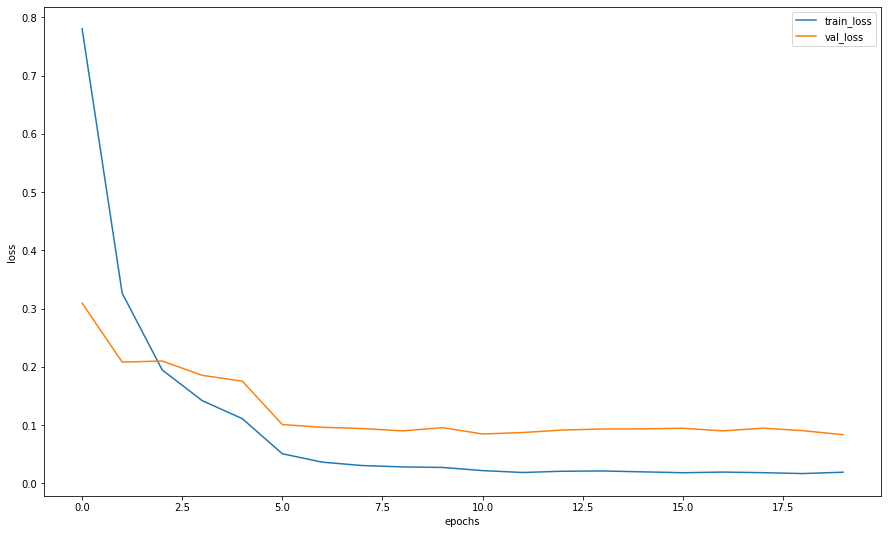

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Предсказание на тестовых данных и оформление submit-а.

In [27]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [28]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [29]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [31]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
preds_class = label_encoder.transform(preds_class)

Вычислю метрику f1 на валидационной выборке.

In [32]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

1.0

Использую классную визуализацию из baseline-а, чтобы взглянуть на "уверенность" модели на случайных примерах.

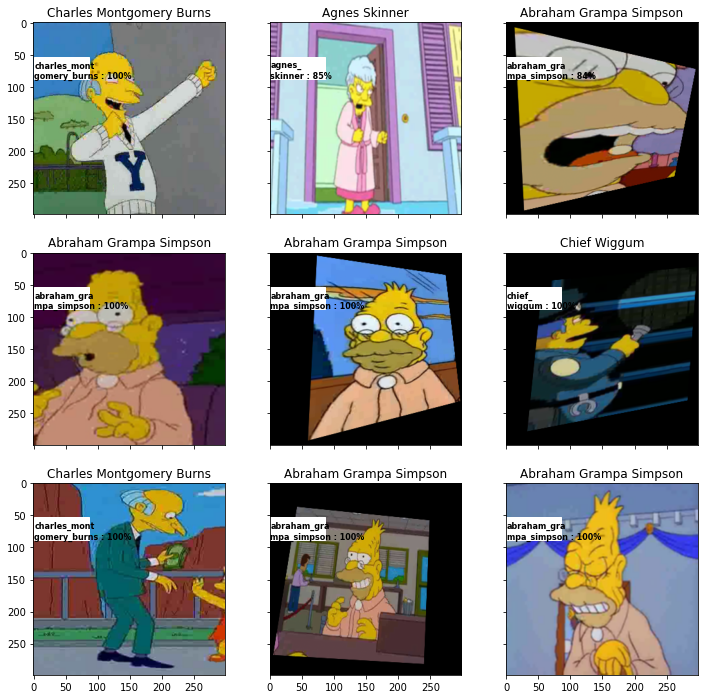

In [33]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
#     font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

Использую готовый шаблон подготовки submit-а из baseline-ноутбука.

In [34]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [35]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [36]:
! ls 

gdrive	label_encoder.pkl  sample_data	test  train


In [40]:
my_submit.to_csv('resnet50_transfer.csv', index=False)

История результатов посылок. Много забракованных, потому что были проблемы с обозначением столбцов.

[![Foo](https://sun9-east.userapi.com/sun9-43/s/v1/ig2/2HdIONV-pWX8qk7OO3fBHBhrVClz1LYpUY1y5fCucUNBnIi9Mhia7UFBHzXarvHlJ5Q8ps2j_BZsKX71QzKL92mt.jpg?size=1134x574&quality=96&type=album)